In [18]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
np.random.seed(40)   
tf.random.set_seed(40)

In [19]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [21]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(), 'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
        freqQAmpI_filt       C_filt
0        86444.183014  5713.739611
1        86444.358094  5713.748279
2        86442.647757  5713.750421
3        86419.380962  5713.758606
4        86414.552286  5713.772870
...               ...          ...
75994    81488.107323  5720.364457
75995    81375.846782  5720.365210
75996    81263.154871  5720.384980
75997    81137.502620  5720.393775
75998    80982.695515  5720.397332

[75999 rows x 2 columns]
Target Data:
              SS     V_filt
0      5.893849  10.577261
1      5.893360  10.282278
2      5.893242  10.050505
3      5.893039   9.903014
4      5.892528   9.945154
...         ...        ...
75994  5.850977   0.674248
75995  5.851531   0.653177
75996  5.852108   0.863880
75997  5.852526   0.716388
75998  5.852725   0.863880

[75999 rows x 2 columns]


In [22]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (75699, 300, 2)
Target shape (SS), Y =  (75699,)
Target shape (V), Y =  (75699,)
After reshaping, X =  (75699, 600)


In [23]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Training Data Percentage 
X_train = X_train[30399:53199] 
Y_train_SS = Y_train_SS[30399:53199]
Y_train_V = Y_train_V[30399:53199]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 22590
Validation samples: 7570
Testing samples: 15140


In [24]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [25]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [26]:
# Define MLP
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate 
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [27]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 64)           8256        ['dense_7[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 32)           2080        ['dense_8[0][0]']                
                                                                                            

Train on 22590 samples, validate on 7570 samples
Epoch 1/100
22080/22590 [============================>.] - ETA: 0s - loss: 0.0538 - dense_12_loss: 0.0423 - dense_13_loss: 0.0115 - dense_12_mse: 0.0423 - dense_13_mse: 0.0115

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.02859, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 5s 203us/sample - loss: 0.0531 - dense_12_loss: 0.0417 - dense_13_loss: 0.0113 - dense_12_mse: 0.0418 - dense_13_mse: 0.0113 - val_loss: 0.0286 - val_dense_12_loss: 0.0215 - val_dense_13_loss: 0.0071 - val_dense_12_mse: 0.0215 - val_dense_13_mse: 0.0071
Epoch 2/100
22432/22590 [============================>.] - ETA: 0s - loss: 0.0230 - dense_12_loss: 0.0171 - dense_13_loss: 0.0059 - dense_12_mse: 0.0171 - dense_13_mse: 0.0059
Epoch 2: val_loss improved from 0.02859 to 0.02450, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 4s 162us/sample - loss: 0.0230 - dense_12_loss: 0.0171 - dense_13_loss: 0.0059 - dense_12_mse: 0.0171 - dense_13_mse: 0.0059 - val_loss: 0.0245 - val_dense_12_loss: 0.0181 - val_dense_13_loss: 0.0064 - val_dense_12_mse: 0.0181 - val_dense_13_mse: 0.0064
Epoch 3/100
22016/22590 [============================>.] - ETA: 0s - loss: 0.0205 - dense_12_loss: 0.0153 - dense_13_loss: 0.0052 - dense_12_mse: 0.0153 - dense_13_mse: 0.0052
Epoch 3: val_loss improved from 0.02450 to 0.02101, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 4s 170us/sample - loss: 0.0204 - dense_12_loss: 0.0153 - dense_13_loss: 0.0051 - dense_12_mse: 0.0153 - dense_13_mse: 0.0051 - val_loss: 0.0210 - val_dense_12_loss: 0.0153 - val_dense_13_loss: 0.0057 - val_dense_12_mse: 0.0153 - val_dense_13_mse: 0.0057
Epoch 4/100
22240/22590 [============================>.] - ETA: 0s - loss: 0.0174 - dense_12_loss: 0.0127 - dense_13_loss: 0.0047 - dense_12_mse: 0.0127 - dense_13_mse: 0.0047
Epoch 4: val_loss improved from 0.02101 to 0.01823, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 4s 161us/sample - loss: 0.0173 - dense_12_loss: 0.0126 - dense_13_loss: 0.0047 - dense_12_mse: 0.0126 - dense_13_mse: 0.0047 - val_loss: 0.0182 - val_dense_12_loss: 0.0129 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0129 - val_dense_13_mse: 0.0054
Epoch 5/100
22464/22590 [============================>.] - ETA: 0s - loss: 0.0147 - dense_12_loss: 0.0102 - dense_13_loss: 0.0045 - dense_12_mse: 0.0102 - dense_13_mse: 0.0045
Epoch 5: val_loss improved from 0.01823 to 0.01431, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 4s 182us/sample - loss: 0.0147 - dense_12_loss: 0.0102 - dense_13_loss: 0.0045 - dense_12_mse: 0.0102 - dense_13_mse: 0.0045 - val_loss: 0.0143 - val_dense_12_loss: 0.0092 - val_dense_13_loss: 0.0051 - val_dense_12_mse: 0.0092 - val_dense_13_mse: 0.0051
Epoch 6/100
22496/22590 [============================>.] - ETA: 0s - loss: 0.0124 - dense_12_loss: 0.0081 - dense_13_loss: 0.0043 - dense_12_mse: 0.0081 - dense_13_mse: 0.0043
Epoch 6: val_loss did not improve from 0.01431
22590/22590 [==============================] - 2s 94us/sample - loss: 0.0124 - dense_12_loss: 0.0081 - dense_13_loss: 0.0043 - dense_12_mse: 0.0081 - dense_13_mse: 0.0043 - val_loss: 0.0202 - val_dense_12_loss: 0.0151 - val_dense_13_loss: 0.0051 - val_dense_12_mse: 0.0151 - val_dense_13_mse: 0.0051
Epoch 7/100
22496/22590 [============================>.] - ETA: 0s - loss: 0.0112 - dense_12_loss: 0.0072 - dense_13_loss: 0.0040 - dense_12_mse: 0.0072 - dense_13_mse: 0.0040


22590/22590 [==============================] - 3s 144us/sample - loss: 0.0102 - dense_12_loss: 0.0066 - dense_13_loss: 0.0036 - dense_12_mse: 0.0066 - dense_13_mse: 0.0036 - val_loss: 0.0109 - val_dense_12_loss: 0.0070 - val_dense_13_loss: 0.0039 - val_dense_12_mse: 0.0070 - val_dense_13_mse: 0.0039
Epoch 9/100
22208/22590 [============================>.] - ETA: 0s - loss: 0.0095 - dense_12_loss: 0.0063 - dense_13_loss: 0.0032 - dense_12_mse: 0.0063 - dense_13_mse: 0.0032
Epoch 9: val_loss improved from 0.01093 to 0.00903, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 4s 168us/sample - loss: 0.0095 - dense_12_loss: 0.0063 - dense_13_loss: 0.0032 - dense_12_mse: 0.0063 - dense_13_mse: 0.0032 - val_loss: 0.0090 - val_dense_12_loss: 0.0058 - val_dense_13_loss: 0.0032 - val_dense_12_mse: 0.0058 - val_dense_13_mse: 0.0032
Epoch 10/100
22272/22590 [============================>.] - ETA: 0s - loss: 0.0081 - dense_12_loss: 0.0053 - dense_13_loss: 0.0027 - dense_12_mse: 0.0053 - dense_13_mse: 0.0027
Epoch 10: val_loss improved from 0.00903 to 0.00834, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 4s 161us/sample - loss: 0.0081 - dense_12_loss: 0.0053 - dense_13_loss: 0.0027 - dense_12_mse: 0.0053 - dense_13_mse: 0.0027 - val_loss: 0.0083 - val_dense_12_loss: 0.0055 - val_dense_13_loss: 0.0028 - val_dense_12_mse: 0.0055 - val_dense_13_mse: 0.0028
Epoch 11/100
22336/22590 [============================>.] - ETA: 0s - loss: 0.0077 - dense_12_loss: 0.0051 - dense_13_loss: 0.0026 - dense_12_mse: 0.0051 - dense_13_mse: 0.0026
Epoch 11: val_loss improved from 0.00834 to 0.00766, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 4s 160us/sample - loss: 0.0077 - dense_12_loss: 0.0051 - dense_13_loss: 0.0026 - dense_12_mse: 0.0051 - dense_13_mse: 0.0026 - val_loss: 0.0077 - val_dense_12_loss: 0.0052 - val_dense_13_loss: 0.0024 - val_dense_12_mse: 0.0052 - val_dense_13_mse: 0.0024
Epoch 12/100
22528/22590 [============================>.] - ETA: 0s - loss: 0.0070 - dense_12_loss: 0.0046 - dense_13_loss: 0.0024 - dense_12_mse: 0.0046 - dense_13_mse: 0.0024
Epoch 12: val_loss improved from 0.00766 to 0.00728, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 4s 161us/sample - loss: 0.0070 - dense_12_loss: 0.0046 - dense_13_loss: 0.0024 - dense_12_mse: 0.0046 - dense_13_mse: 0.0024 - val_loss: 0.0073 - val_dense_12_loss: 0.0050 - val_dense_13_loss: 0.0023 - val_dense_12_mse: 0.0050 - val_dense_13_mse: 0.0023
Epoch 13/100
22272/22590 [============================>.] - ETA: 0s - loss: 0.0063 - dense_12_loss: 0.0041 - dense_13_loss: 0.0022 - dense_12_mse: 0.0041 - dense_13_mse: 0.0022
Epoch 13: val_loss improved from 0.00728 to 0.00663, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 4s 169us/sample - loss: 0.0063 - dense_12_loss: 0.0041 - dense_13_loss: 0.0022 - dense_12_mse: 0.0041 - dense_13_mse: 0.0022 - val_loss: 0.0066 - val_dense_12_loss: 0.0047 - val_dense_13_loss: 0.0019 - val_dense_12_mse: 0.0047 - val_dense_13_mse: 0.0019
Epoch 14/100
22304/22590 [============================>.] - ETA: 0s - loss: 0.0059 - dense_12_loss: 0.0039 - dense_13_loss: 0.0020 - dense_12_mse: 0.0039 - dense_13_mse: 0.0020
Epoch 14: val_loss improved from 0.00663 to 0.00636, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 4s 178us/sample - loss: 0.0059 - dense_12_loss: 0.0039 - dense_13_loss: 0.0020 - dense_12_mse: 0.0039 - dense_13_mse: 0.0020 - val_loss: 0.0064 - val_dense_12_loss: 0.0045 - val_dense_13_loss: 0.0018 - val_dense_12_mse: 0.0045 - val_dense_13_mse: 0.0018
Epoch 15/100
22304/22590 [============================>.] - ETA: 0s - loss: 0.0061 - dense_12_loss: 0.0040 - dense_13_loss: 0.0021 - dense_12_mse: 0.0040 - dense_13_mse: 0.0021
Epoch 15: val_loss improved from 0.00636 to 0.00620, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 4s 167us/sample - loss: 0.0061 - dense_12_loss: 0.0040 - dense_13_loss: 0.0021 - dense_12_mse: 0.0040 - dense_13_mse: 0.0021 - val_loss: 0.0062 - val_dense_12_loss: 0.0043 - val_dense_13_loss: 0.0019 - val_dense_12_mse: 0.0043 - val_dense_13_mse: 0.0019
Epoch 16/100
22112/22590 [============================>.] - ETA: 0s - loss: 0.0054 - dense_12_loss: 0.0036 - dense_13_loss: 0.0018 - dense_12_mse: 0.0036 - dense_13_mse: 0.0018
Epoch 16: val_loss improved from 0.00620 to 0.00568, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 3s 152us/sample - loss: 0.0054 - dense_12_loss: 0.0036 - dense_13_loss: 0.0018 - dense_12_mse: 0.0036 - dense_13_mse: 0.0018 - val_loss: 0.0057 - val_dense_12_loss: 0.0042 - val_dense_13_loss: 0.0015 - val_dense_12_mse: 0.0042 - val_dense_13_mse: 0.0015
Epoch 17/100
21984/22590 [============================>.] - ETA: 0s - loss: 0.0052 - dense_12_loss: 0.0035 - dense_13_loss: 0.0017 - dense_12_mse: 0.0035 - dense_13_mse: 0.0017
Epoch 17: val_loss did not improve from 0.00568
22590/22590 [==============================] - 2s 84us/sample - loss: 0.0052 - dense_12_loss: 0.0035 - dense_13_loss: 0.0017 - dense_12_mse: 0.0035 - dense_13_mse: 0.0017 - val_loss: 0.0087 - val_dense_12_loss: 0.0055 - val_dense_13_loss: 0.0032 - val_dense_12_mse: 0.0055 - val_dense_13_mse: 0.0032
Epoch 18/100
21952/22590 [============================>.] - ETA: 0s - loss: 0.0051 - dense_12_loss: 0.0034 - dense_13_loss: 0.0016 - dense_12_mse: 0.0034 - dense_13_mse: 0.00

22590/22590 [==============================] - 3s 150us/sample - loss: 0.0051 - dense_12_loss: 0.0034 - dense_13_loss: 0.0016 - dense_12_mse: 0.0034 - dense_13_mse: 0.0016 - val_loss: 0.0049 - val_dense_12_loss: 0.0037 - val_dense_13_loss: 0.0013 - val_dense_12_mse: 0.0037 - val_dense_13_mse: 0.0013
Epoch 19/100
22048/22590 [============================>.] - ETA: 0s - loss: 0.0049 - dense_12_loss: 0.0033 - dense_13_loss: 0.0016 - dense_12_mse: 0.0033 - dense_13_mse: 0.0016
Epoch 19: val_loss did not improve from 0.00493
22590/22590 [==============================] - 2s 90us/sample - loss: 0.0049 - dense_12_loss: 0.0033 - dense_13_loss: 0.0016 - dense_12_mse: 0.0033 - dense_13_mse: 0.0016 - val_loss: 0.0051 - val_dense_12_loss: 0.0036 - val_dense_13_loss: 0.0015 - val_dense_12_mse: 0.0036 - val_dense_13_mse: 0.0015
Epoch 20/100
22176/22590 [============================>.] - ETA: 0s - loss: 0.0047 - dense_12_loss: 0.0032 - dense_13_loss: 0.0015 - dense_12_mse: 0.0032 - dense_13_mse: 0.00

22590/22590 [==============================] - 4s 191us/sample - loss: 0.0047 - dense_12_loss: 0.0032 - dense_13_loss: 0.0015 - dense_12_mse: 0.0032 - dense_13_mse: 0.0015 - val_loss: 0.0047 - val_dense_12_loss: 0.0035 - val_dense_13_loss: 0.0012 - val_dense_12_mse: 0.0035 - val_dense_13_mse: 0.0012
Epoch 21/100
21984/22590 [============================>.] - ETA: 0s - loss: 0.0046 - dense_12_loss: 0.0032 - dense_13_loss: 0.0015 - dense_12_mse: 0.0032 - dense_13_mse: 0.0015
Epoch 21: val_loss did not improve from 0.00473
22590/22590 [==============================] - 2s 86us/sample - loss: 0.0047 - dense_12_loss: 0.0032 - dense_13_loss: 0.0015 - dense_12_mse: 0.0032 - dense_13_mse: 0.0015 - val_loss: 0.0064 - val_dense_12_loss: 0.0048 - val_dense_13_loss: 0.0016 - val_dense_12_mse: 0.0048 - val_dense_13_mse: 0.0016
Epoch 22/100
22048/22590 [============================>.] - ETA: 0s - loss: 0.0044 - dense_12_loss: 0.0030 - dense_13_loss: 0.0014 - dense_12_mse: 0.0030 - dense_13_mse: 0.00

22590/22590 [==============================] - 4s 181us/sample - loss: 0.0046 - dense_12_loss: 0.0032 - dense_13_loss: 0.0014 - dense_12_mse: 0.0032 - dense_13_mse: 0.0014 - val_loss: 0.0047 - val_dense_12_loss: 0.0037 - val_dense_13_loss: 0.0010 - val_dense_12_mse: 0.0036 - val_dense_13_mse: 0.0010
Epoch 24/100
22432/22590 [============================>.] - ETA: 0s - loss: 0.0042 - dense_12_loss: 0.0029 - dense_13_loss: 0.0014 - dense_12_mse: 0.0029 - dense_13_mse: 0.0014
Epoch 24: val_loss did not improve from 0.00466
22590/22590 [==============================] - 2s 96us/sample - loss: 0.0042 - dense_12_loss: 0.0029 - dense_13_loss: 0.0014 - dense_12_mse: 0.0029 - dense_13_mse: 0.0014 - val_loss: 0.0069 - val_dense_12_loss: 0.0052 - val_dense_13_loss: 0.0018 - val_dense_12_mse: 0.0052 - val_dense_13_mse: 0.0018
Epoch 25/100
22272/22590 [============================>.] - ETA: 0s - loss: 0.0042 - dense_12_loss: 0.0029 - dense_13_loss: 0.0013 - dense_12_mse: 0.0029 - dense_13_mse: 0.00

22590/22590 [==============================] - 4s 162us/sample - loss: 0.0038 - dense_12_loss: 0.0026 - dense_13_loss: 0.0012 - dense_12_mse: 0.0026 - dense_13_mse: 0.0012 - val_loss: 0.0044 - val_dense_12_loss: 0.0035 - val_dense_13_loss: 9.1028e-04 - val_dense_12_mse: 0.0035 - val_dense_13_mse: 9.0510e-04
Epoch 30/100
22208/22590 [============================>.] - ETA: 0s - loss: 0.0038 - dense_12_loss: 0.0026 - dense_13_loss: 0.0012 - dense_12_mse: 0.0026 - dense_13_mse: 0.0012
Epoch 30: val_loss did not improve from 0.00438
22590/22590 [==============================] - 2s 94us/sample - loss: 0.0038 - dense_12_loss: 0.0026 - dense_13_loss: 0.0012 - dense_12_mse: 0.0026 - dense_13_mse: 0.0012 - val_loss: 0.0053 - val_dense_12_loss: 0.0042 - val_dense_13_loss: 0.0011 - val_dense_12_mse: 0.0042 - val_dense_13_mse: 0.0011
Epoch 31/100
22240/22590 [============================>.] - ETA: 0s - loss: 0.0036 - dense_12_loss: 0.0025 - dense_13_loss: 0.0011 - dense_12_mse: 0.0025 - dense_13_m

22590/22590 [==============================] - 4s 172us/sample - loss: 0.0033 - dense_12_loss: 0.0023 - dense_13_loss: 0.0011 - dense_12_mse: 0.0023 - dense_13_mse: 0.0011 - val_loss: 0.0043 - val_dense_12_loss: 0.0035 - val_dense_13_loss: 8.2499e-04 - val_dense_12_mse: 0.0035 - val_dense_13_mse: 8.2340e-04
Epoch 35/100
22016/22590 [============================>.] - ETA: 0s - loss: 0.0033 - dense_12_loss: 0.0023 - dense_13_loss: 0.0010 - dense_12_mse: 0.0023 - dense_13_mse: 0.0010
Epoch 35: val_loss did not improve from 0.00429
22590/22590 [==============================] - 2s 85us/sample - loss: 0.0033 - dense_12_loss: 0.0023 - dense_13_loss: 0.0010 - dense_12_mse: 0.0023 - dense_13_mse: 0.0010 - val_loss: 0.0048 - val_dense_12_loss: 0.0038 - val_dense_13_loss: 0.0010 - val_dense_12_mse: 0.0038 - val_dense_13_mse: 0.0011
Epoch 36/100
22144/22590 [============================>.] - ETA: 0s - loss: 0.0031 - dense_12_loss: 0.0021 - dense_13_loss: 9.3835e-04 - dense_12_mse: 0.0021 - dense_

22590/22590 [==============================] - 3s 151us/sample - loss: 0.0031 - dense_12_loss: 0.0021 - dense_13_loss: 9.4155e-04 - dense_12_mse: 0.0021 - dense_13_mse: 9.4135e-04 - val_loss: 0.0042 - val_dense_12_loss: 0.0035 - val_dense_13_loss: 7.0908e-04 - val_dense_12_mse: 0.0035 - val_dense_13_mse: 7.0816e-04
Epoch 37/100
22176/22590 [============================>.] - ETA: 0s - loss: 0.0031 - dense_12_loss: 0.0021 - dense_13_loss: 9.5846e-04 - dense_12_mse: 0.0021 - dense_13_mse: 9.5846e-04
Epoch 37: val_loss did not improve from 0.00421
22590/22590 [==============================] - 2s 103us/sample - loss: 0.0031 - dense_12_loss: 0.0021 - dense_13_loss: 9.4955e-04 - dense_12_mse: 0.0021 - dense_13_mse: 9.4956e-04 - val_loss: 0.0043 - val_dense_12_loss: 0.0035 - val_dense_13_loss: 7.7893e-04 - val_dense_12_mse: 0.0035 - val_dense_13_mse: 7.6706e-04
Epoch 38/100
22336/22590 [============================>.] - ETA: 0s - loss: 0.0032 - dense_12_loss: 0.0022 - dense_13_loss: 0.0010 - 

22590/22590 [==============================] - 4s 182us/sample - loss: 0.0030 - dense_12_loss: 0.0020 - dense_13_loss: 9.3967e-04 - dense_12_mse: 0.0020 - dense_13_mse: 9.3975e-04 - val_loss: 0.0039 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 6.3399e-04 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 6.3175e-04
Epoch 42/100
22464/22590 [============================>.] - ETA: 0s - loss: 0.0028 - dense_12_loss: 0.0020 - dense_13_loss: 8.6693e-04 - dense_12_mse: 0.0020 - dense_13_mse: 8.6693e-04
Epoch 42: val_loss did not improve from 0.00392
22590/22590 [==============================] - 2s 100us/sample - loss: 0.0028 - dense_12_loss: 0.0020 - dense_13_loss: 8.7053e-04 - dense_12_mse: 0.0020 - dense_13_mse: 8.7046e-04 - val_loss: 0.0058 - val_dense_12_loss: 0.0041 - val_dense_13_loss: 0.0018 - val_dense_12_mse: 0.0041 - val_dense_13_mse: 0.0018
Epoch 43/100
22560/22590 [============================>.] - ETA: 0s - loss: 0.0029 - dense_12_loss: 0.0019 - dense_13_loss: 9.1356e-04 - dens

22590/22590 [==============================] - 4s 165us/sample - loss: 0.0028 - dense_12_loss: 0.0020 - dense_13_loss: 8.6405e-04 - dense_12_mse: 0.0020 - dense_13_mse: 8.6412e-04 - val_loss: 0.0039 - val_dense_12_loss: 0.0031 - val_dense_13_loss: 7.9823e-04 - val_dense_12_mse: 0.0031 - val_dense_13_mse: 7.9712e-04
Epoch 46/100
22528/22590 [============================>.] - ETA: 0s - loss: 0.0027 - dense_12_loss: 0.0019 - dense_13_loss: 8.1892e-04 - dense_12_mse: 0.0019 - dense_13_mse: 8.1892e-04
Epoch 46: val_loss improved from 0.00386 to 0.00386, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 4s 174us/sample - loss: 0.0027 - dense_12_loss: 0.0019 - dense_13_loss: 8.2479e-04 - dense_12_mse: 0.0019 - dense_13_mse: 8.2444e-04 - val_loss: 0.0039 - val_dense_12_loss: 0.0030 - val_dense_13_loss: 8.9450e-04 - val_dense_12_mse: 0.0030 - val_dense_13_mse: 8.9613e-04
Epoch 47/100
22560/22590 [============================>.] - ETA: 0s - loss: 0.0026 - dense_12_loss: 0.0018 - dense_13_loss: 8.3967e-04 - dense_12_mse: 0.0018 - dense_13_mse: 8.3967e-04
Epoch 47: val_loss did not improve from 0.00386
22590/22590 [==============================] - 3s 111us/sample - loss: 0.0026 - dense_12_loss: 0.0018 - dense_13_loss: 8.3872e-04 - dense_12_mse: 0.0018 - dense_13_mse: 8.3878e-04 - val_loss: 0.0041 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 7.7282e-04 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 7.7014e-04
Epoch 48/100
22528/22590 [============================>.] - ETA: 0s - loss: 0.0026 - dense_12_loss: 0.0018 - dense_13_loss: 7.9344e-0

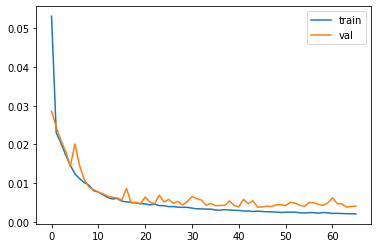

---Training time: 182.63298154 seconds ---


In [28]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto') 
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [29]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.95931, Train (V) - 0.83361
R2 scores: Validation (SS) - 0.92299, Validation (V) - 0.81188
R2 scores: Testing (SS) - 0.79513, Testing (V) - 0.61019
RMSE scores: Train (SS) - 0.03618, Train (V) - 0.02799
RMSE scores: Validation (SS) - 0.05511, Validation (V) - 0.03227
RMSE scores: Testing (SS) - 0.09743, Testing (V) - 0.05325


In [30]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [31]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

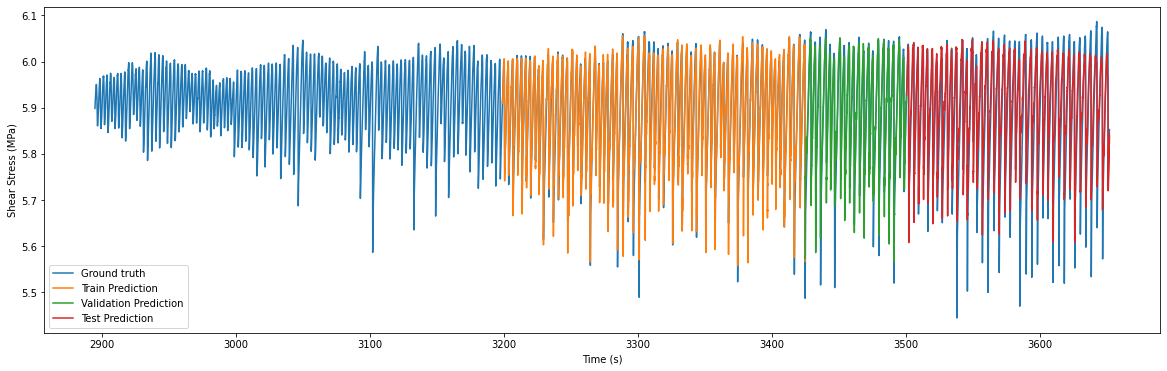

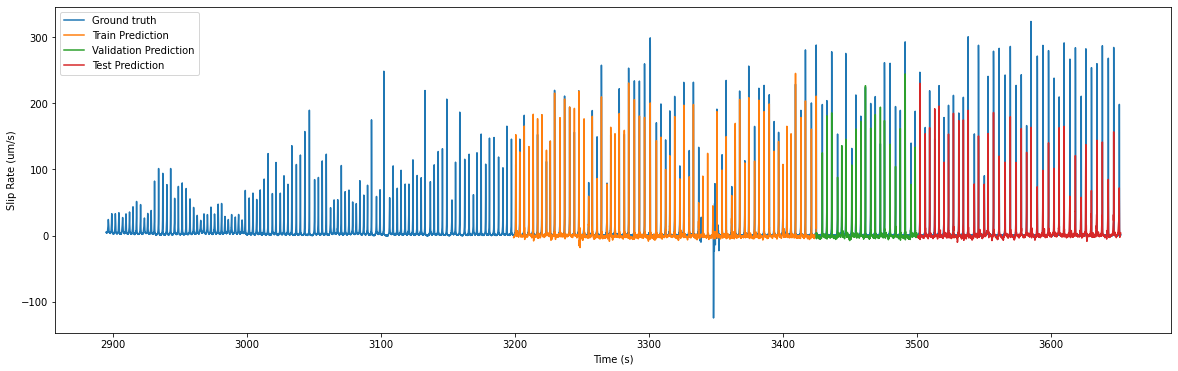

In [32]:
# Overall plot: SS & V
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[30399:53199] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

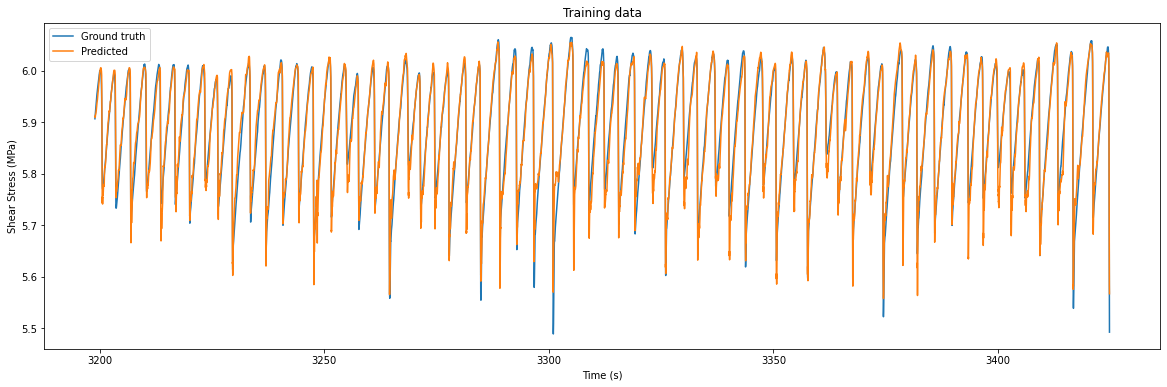

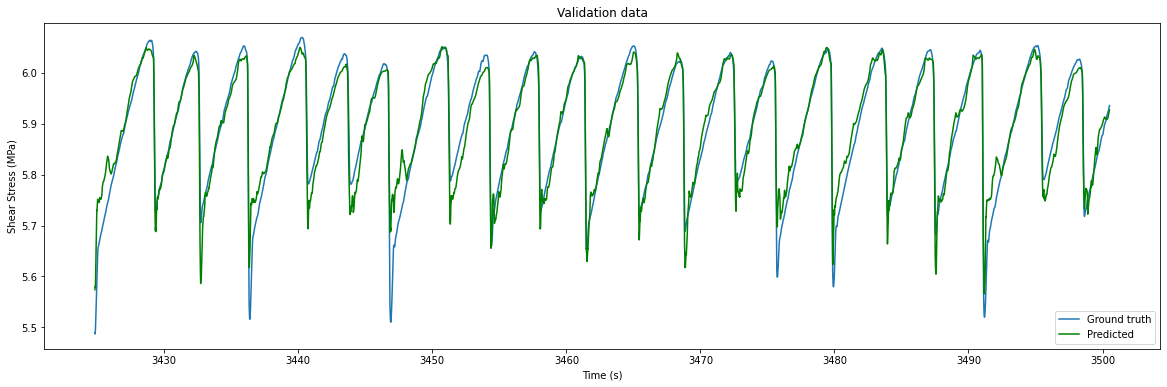

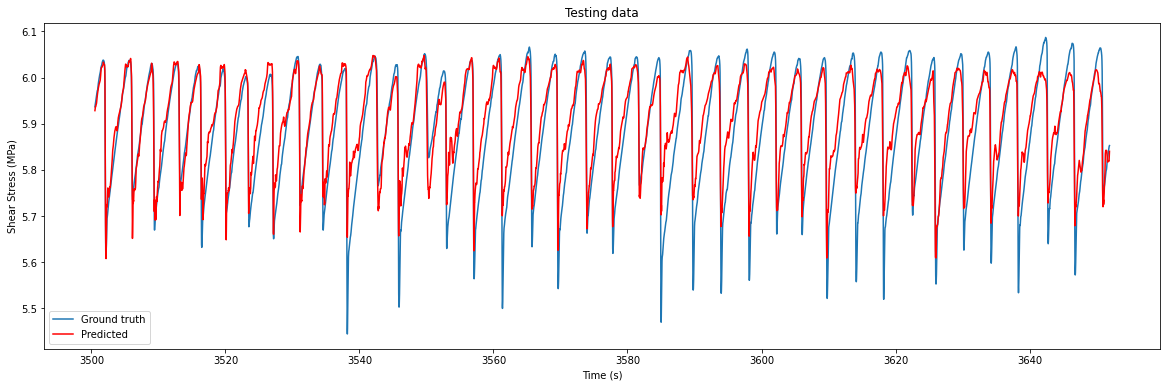

In [33]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

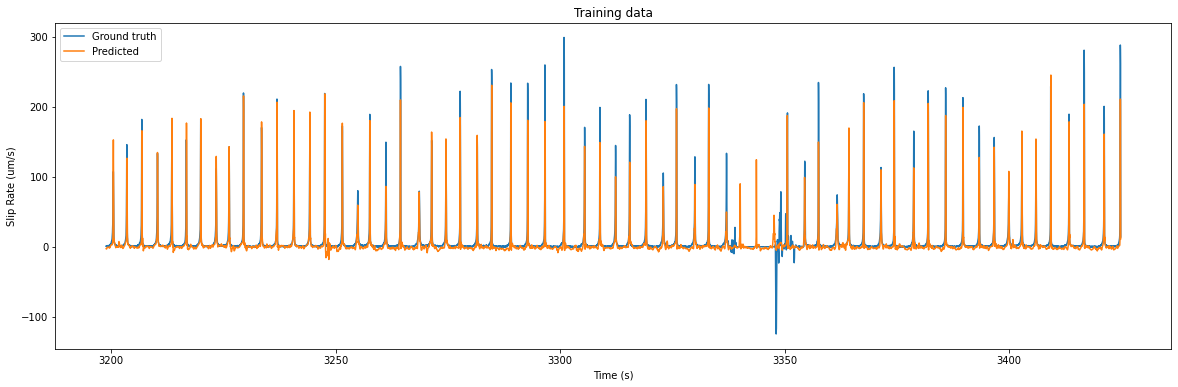

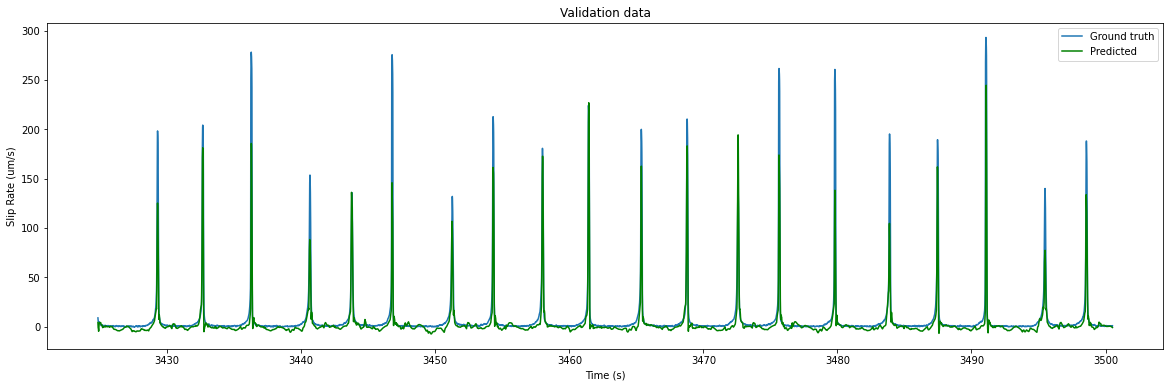

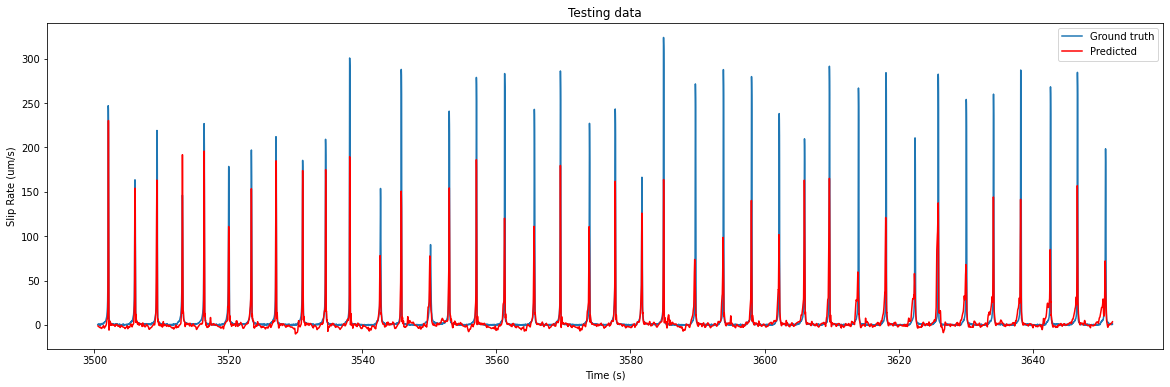

In [34]:
# # Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')